In [78]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from constants import ROOT_DIR

# Lecture des fichiers

## Content
The dataset contains a sample of user interactions (page views) in G1 news portal from Oct. 1 to 16, 2017, including about 3 million clicks, distributed in more than 1 million sessions from 314,000 users who read more than 46,000 different news articles during that period.

It is composed by three files/folders:
- clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
- articles_metadata.csv - CSV file with metadata information about all (364047) published articles
- articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.


P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.


In [79]:
DATA_DIR = ROOT_DIR / "data"
CLICKS_DIR = DATA_DIR / "unzip_clicks"
WORK_DIR = DATA_DIR / "workbase"

## Clicks.zip


In [80]:
# List every file in the clicks directory with glob
clicks_files = glob(str(CLICKS_DIR / "*.csv"))
n_hours = len(clicks_files)
print(f"Number of hours of clicks data: {n_hours}")
print(f"Number of days of clicks data: {n_hours // 24}")

# Read all CSV files into a list of DataFrames
clicks_dfs = [pd.read_csv(file) for file in clicks_files]
# Concatenate all DataFrames into a single DataFrame
clicks_df = pd.concat(clicks_dfs, ignore_index=True)
print(f"Shape of concatenated clicks DataFrame: {clicks_df.shape}")

Number of hours of clicks data: 385
Number of days of clicks data: 16
Shape of concatenated clicks DataFrame: (2988181, 12)
Shape of concatenated clicks DataFrame: (2988181, 12)


In [81]:
print(clicks_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB
None


In [82]:
# Quick health check about missing values
print("Missing values in clicks DataFrame:")
print(clicks_df.isnull().sum())

# Quick health check about duplicates
print("\nNumber of duplicate rows in clicks DataFrame:")
print(clicks_df.duplicated().sum())

Missing values in clicks DataFrame:
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

Number of duplicate rows in clicks DataFrame:
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

Number of duplicate rows in clicks DataFrame:
0
0


In [83]:
clicks_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,51518,1508150180222851,1508150180000,2,336254,1508151096676,4,1,17,1,9,2
1,51518,1508150180222851,1508150180000,2,157478,1508151126676,4,1,17,1,9,2
2,5518,1508150180837852,1508150180000,3,207603,1508150468546,4,1,17,1,20,1
3,5518,1508150180837852,1508150180000,3,272802,1508150616670,4,1,17,1,20,1
4,5518,1508150180837852,1508150180000,3,158179,1508150646670,4,1,17,1,20,1


### Synthèse des colonnes du DataFrame `clicks_df`

| Colonne              | Type           | Rôle/Relation           |
|----------------------|----------------|-------------------------|
| user_id              | clé primaire   | clé Parent - utilisateur    |
| session_id           | clé primaire   | clé Child(user_id) - session |
| session_size         | discrète       | Nbre de clicks/session, 1-1 avec session_id |
| session_start        | timestamp      | Début de session, 1-1 avec session_id |
| click_article_id     | clé primaire   | clé Child(session_id) - article |
| click_timestamp      | timestamp      | Moment du clic, 1-1 avec click_article_id |
| click_environment    | catégorielle   | Environnement de navigation |
| click_deviceGroup    | catégorielle   | Type d'appareil         |
| click_os             | catégorielle   | Système d'exploitation  |
| click_country        | catégorielle   | Pays                    |
| click_region         | catégorielle   | Région                  |
| click_referrer_type  | catégorielle   | Type de référent        |

- **clé primaire** : identifiant unique (parent/child selon la hiérarchie)
- **discrète** : variable numérique discrète
- **catégorielle** : variable qualitative
- **timestamp** : date/heure

In [84]:
# Define timestamps columns
timestamp_cols = ["session_start", "click_timestamp"]

# Convert timestamp columns to datetime and numeric types to best integer type to save memory
clicks_df = clicks_df.assign(
    **{
        col: lambda df, col=col: pd.to_datetime(df[col], unit="ms")
        for col in timestamp_cols
    }
).assign(
    **{
        col: lambda df, col=col: pd.to_numeric(df[col], downcast="integer")
        for col in clicks_df.columns
        if col not in timestamp_cols
    }
)

In [85]:
# Quick health check about missing values
print("Missing values in clicks DataFrame:")
print(clicks_df.isnull().sum())

# Quick health check about duplicates
print("\nNumber of duplicate rows in clicks DataFrame:")
print(clicks_df.duplicated().sum())

Missing values in clicks DataFrame:
user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

Number of duplicate rows in clicks DataFrame:
0
0


**user_id**: Unique identifier of the user (anonymized).

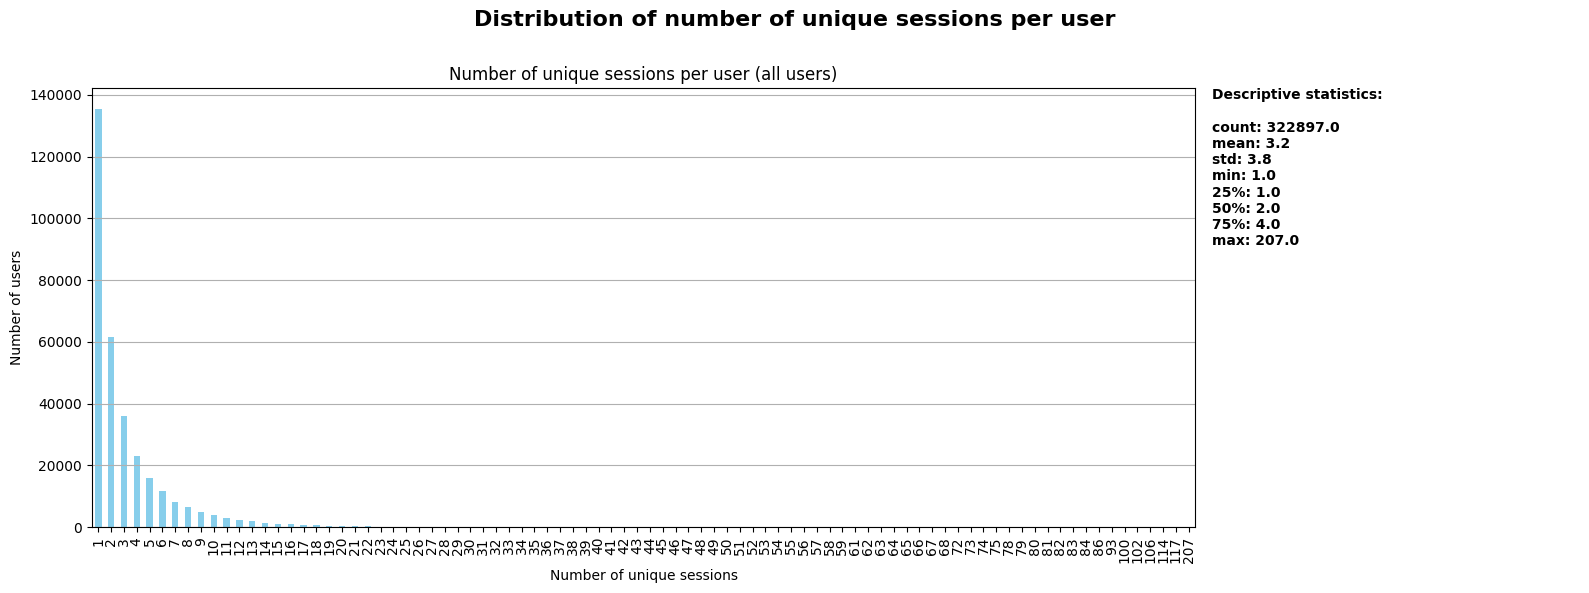

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [3, 1]})

df = clicks_df.groupby("user_id")["session_id"].nunique()

fig.suptitle(
    "Distribution of number of unique sessions per user",
    fontsize=16,
    fontweight="bold",
)

df.value_counts().sort_index().plot(
    kind="bar",
    title="Number of unique sessions per user (all users)",
    ax=ax[0],
    color="skyblue",
)
ax[0].set_xlabel("Number of unique sessions")
ax[0].set_ylabel("Number of users")
ax[0].grid(axis="y")

stats_text = "\n".join([f"{key}: {value:.1f}" for key, value in df.describe().items()])
stats_text = "Descriptive statistics:\n\n" + stats_text

ax[1].text(
    0.0,
    1.0,
    stats_text,
    transform=ax[1].transAxes,
    fontsize=10,
    fontweight="bold",
    verticalalignment="top",
    horizontalalignment="left",
)
ax[1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Analyse de la distribution :
- 322 897 utilisateurs uniques
- Une longue queue vers la droite pour le nombre de sessions par utilisateur avec présence de valeurs extrêmes (ex. max 207 sessions pour un utilisateur)
- Aggrégation des profils de session par utilisateur à prévoir (à définir entre moyenne, somme, pondération manuelle (+ de poids pour session plus récente) ou encore par concaténation avec un historique temporel continu)

**session_id**: Unique identifier of the session (anonymized).

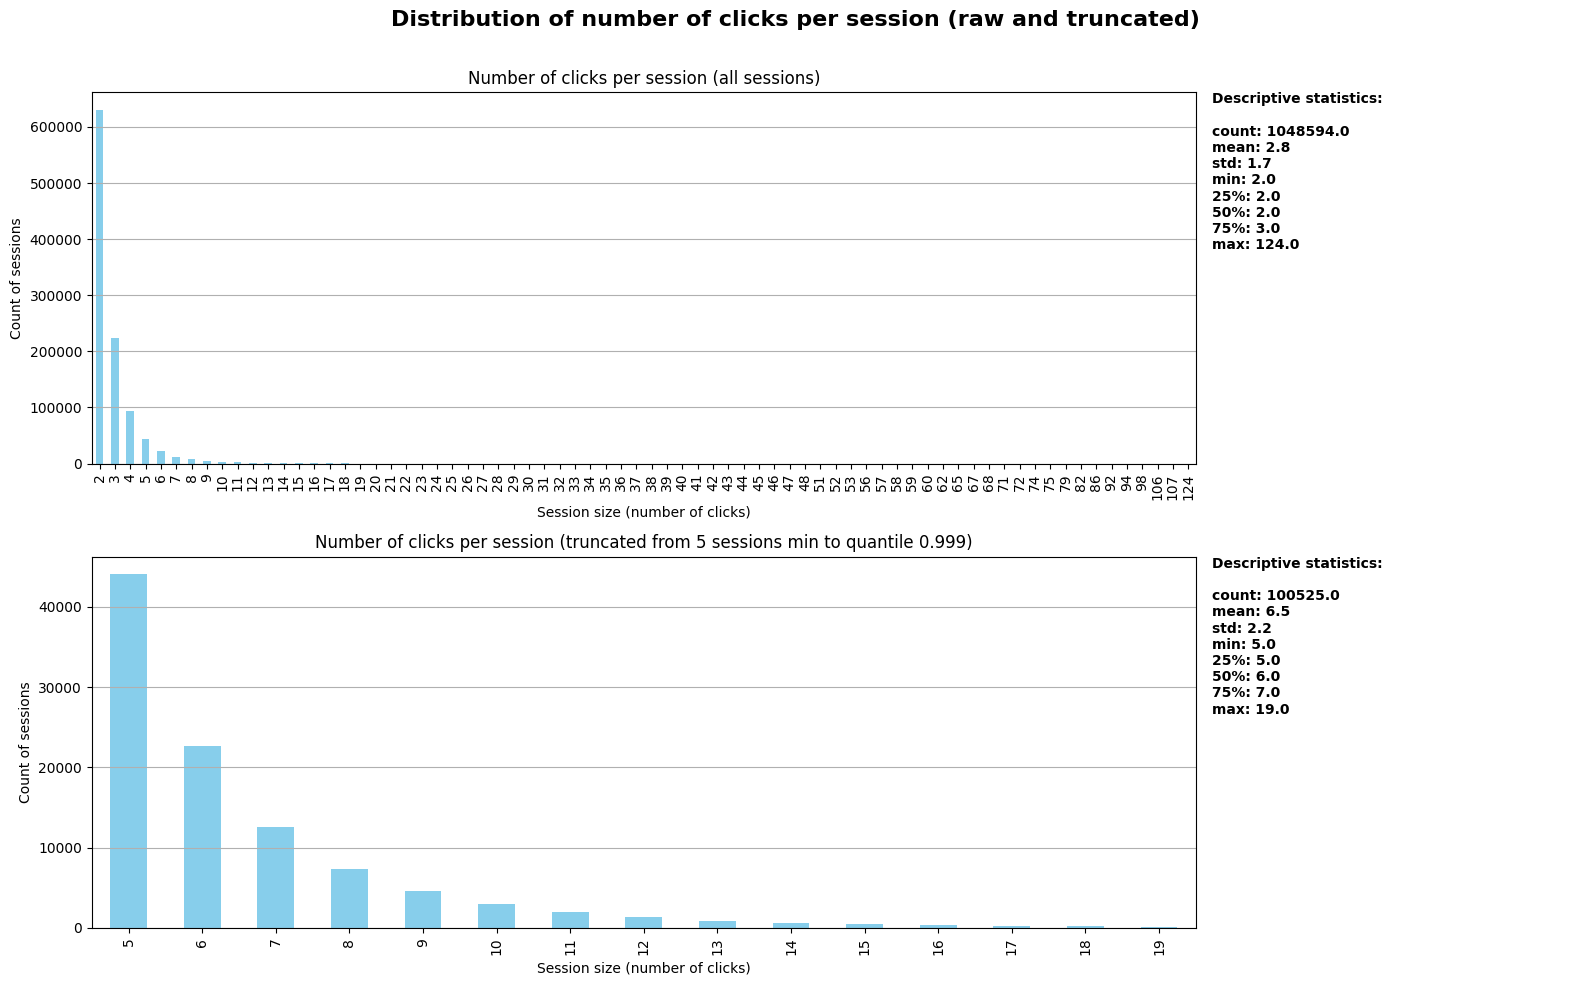

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={"width_ratios": [3, 1]})

session_counts = clicks_df.groupby("session_id").size()
session_counts_truncated = session_counts.pipe(
    lambda s: s[(s <= s.quantile(0.999)) & (s >= 5)]
)
fig.suptitle(
    "Distribution of number of clicks per session (raw and truncated)",
    fontsize=16,
    fontweight="bold",
)
for i, df in enumerate([session_counts, session_counts_truncated]):
    df.value_counts().sort_index().plot(
        kind="bar",
        title=(
            "Number of clicks per session (all sessions)"
            if i == 0
            else "Number of clicks per session (truncated from 5 sessions min to quantile 0.999)"
        ),
        ax=ax[i, 0],
        color="skyblue",
    )
    ax[i, 0].set_xlabel("Session size (number of clicks)")
    ax[i, 0].set_ylabel("Count of sessions")
    ax[i, 0].grid(axis="y")
    stats_text = "\n".join(
        [f"{key}: {value:.1f}" for key, value in df.describe().items()]
    )
    stats_text = "Descriptive statistics:\n\n" + stats_text
    ax[i, 1].text(
        0.0,
        1.0,
        stats_text,
        transform=ax[i, 1].transAxes,
        fontsize=10,
        fontweight="bold",
        verticalalignment="top",
        horizontalalignment="left",
    )
    ax[i, 1].axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Analyse de la distribution brute du nombre de clics par session :
- une majorité de sessions très courtes avec une médiane à 2 clics sur l'ensembe des 1 048 594 sessions
- une distribution avec une longue queue à droite, révelant des outliers, et des valeurs extrêmes avec des sessions allant jusqu'à 124 clics (bot?)


Analyse de la distribution tronquée (de 5 clics au quantile 0.999):
- Environ 10% du nombre de sessions de la distribution brute soit 100 525 sessions
- Une médiane à 6 clics, avec un maximum à 19 clics

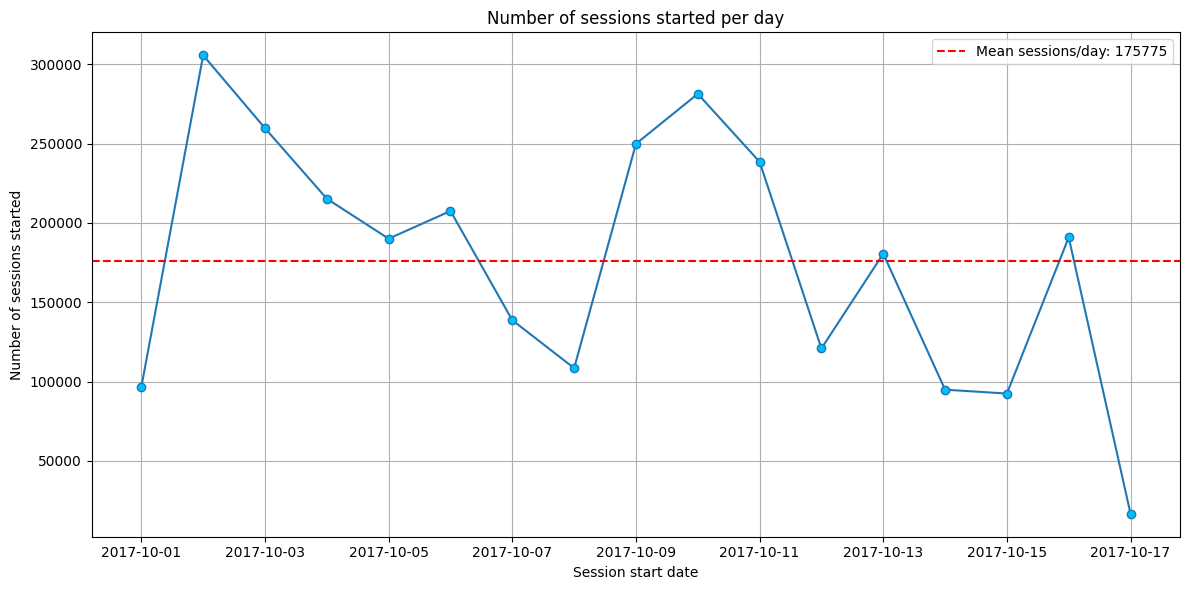

In [88]:
clicks_df.assign(date=lambda x: x["session_start"].dt.date).groupby("date").size().plot(
    kind="line",
    figsize=(12, 6),
    title="Number of sessions started per day",
    xlabel="Session start date",
    ylabel="Number of sessions started",
    marker="o",
    markersize=6,
    markerfacecolor="deepskyblue",
)
# Compute the mean number of sessions started per day
mean_daily_sessions = (
    clicks_df.assign(date=lambda x: x["session_start"].dt.date)
    .groupby("date")
    .size()
    .mean()
)
# add a horizontal line at the mean
plt.axhline(
    mean_daily_sessions,
    color="red",
    linestyle="--",
    label=f"Mean sessions/day: {mean_daily_sessions:.0f}",
)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

**click_article_id**: Unique identifier of the article (anonymized).

In [89]:
print(clicks_df["click_article_id"].value_counts().describe())

count    46033.000000
mean        64.913888
std        629.322888
min          1.000000
25%          1.000000
50%          1.000000
75%          6.000000
max      37213.000000
Name: count, dtype: float64


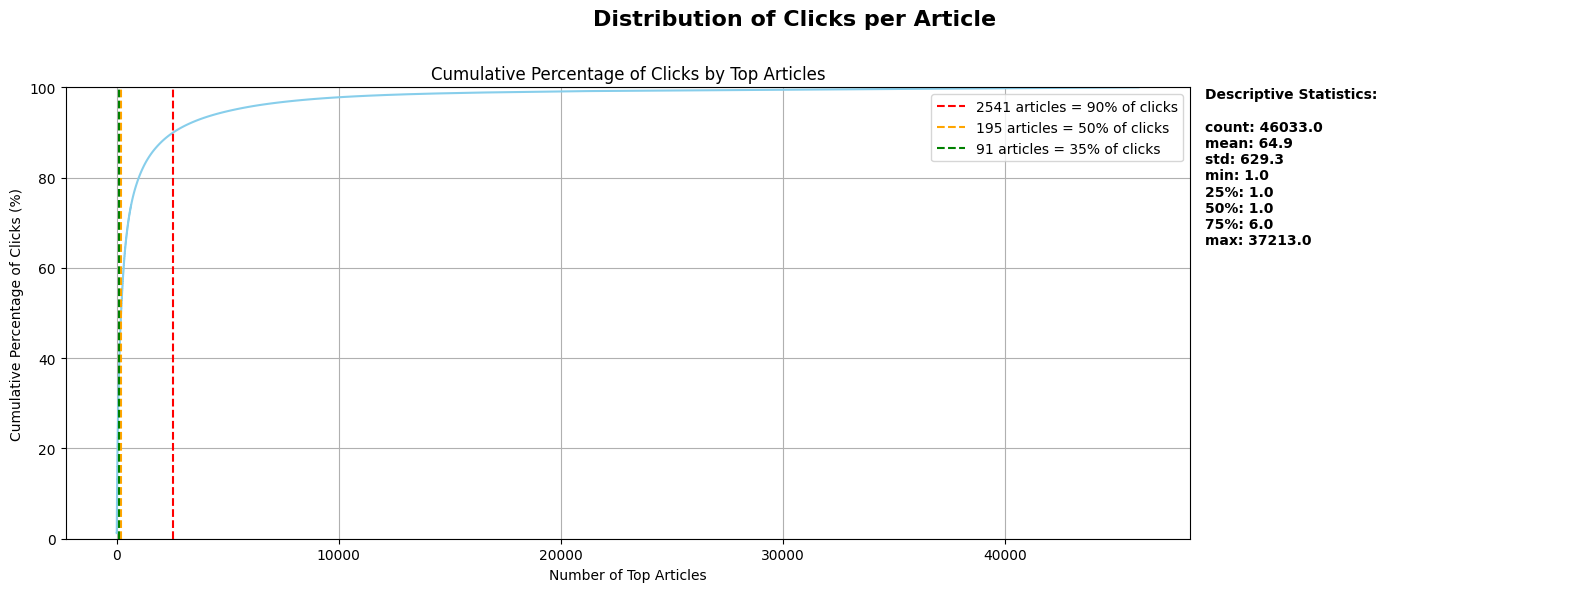

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [3, 1]})

df = clicks_df["click_article_id"].value_counts(ascending=False)

fig.suptitle(
    "Distribution of Clicks per Article",
    fontsize=16,
    fontweight="bold",
)
ax[0].plot(
    range(1, len(df) + 1),
    df.cumsum() / df.cumsum().iloc[-1] * 100,
    drawstyle="steps-post",
    color="skyblue",
)
ax[0].set_xlabel("Number of Top Articles")
ax[0].set_ylabel("Cumulative Percentage of Clicks (%)")
ax[0].set_title("Cumulative Percentage of Clicks by Top Articles")
cumsum_pct = df.cumsum() / df.sum() * 100
ax[0].set_ylim(0, 100)
ax[0].grid()
# Find the number of articles that account for 90% of clicks
n_35 = (cumsum_pct < 35).sum() + 1
n_50 = (cumsum_pct < 50).sum() + 1
n_90 = (cumsum_pct < 90).sum() + 1
ax[0].axvline(
    n_90, color="red", linestyle="--", label=f"{n_90} articles = 90% of clicks"
)
ax[0].axvline(
    n_50, color="orange", linestyle="--", label=f"{n_50} articles = 50% of clicks"
)
ax[0].axvline(
    n_35, color="green", linestyle="--", label=f"{n_35} articles = 35% of clicks"
)
ax[0].legend()
# Display descriptive statistics for the clicks DataFrame
stats_text = "\n".join([f"{key}: {value:.1f}" for key, value in df.describe().items()])

stats_text = "Descriptive Statistics:\n\n" + stats_text

ax[1].text(
    0.0,
    1.0,
    stats_text,
    transform=ax[1].transAxes,
    fontsize=10,
    fontweight="bold",
    verticalalignment="top",
    horizontalalignment="left",
)
ax[1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Analyse de la distribution :
- 46 033 articles uniques
- La grande majorité des clicks sont concentrés sur un très petit nombre d'articles (90% des clicks pour 2541 top articles)

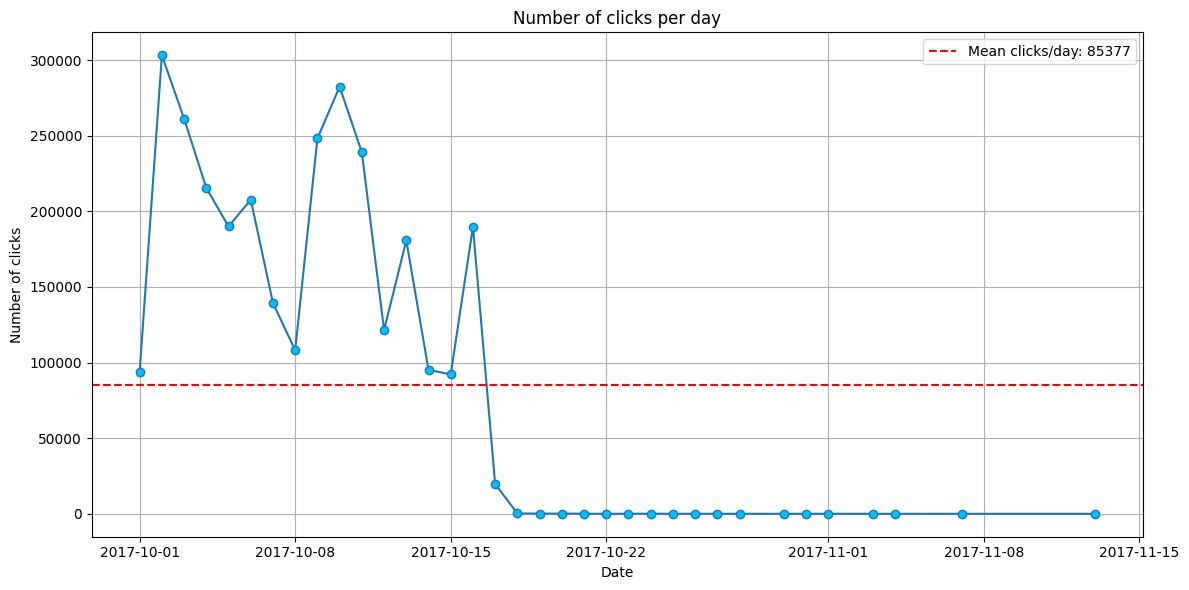

In [91]:
clicks_df.assign(date=lambda x: x["click_timestamp"].dt.date).groupby(
    "date"
).size().plot(
    kind="line",
    figsize=(12, 6),
    title="Number of clicks per day",
    xlabel="Date",
    ylabel="Number of clicks",
    marker="o",
    markersize=6,
    markerfacecolor="deepskyblue",
)
# Compute the mean number of clicks per day
mean_daily_clicks = (
    clicks_df.assign(date=lambda x: x["click_timestamp"].dt.date)
    .groupby("date")
    .size()
    .mean()
)
# add a horizontal line at the mean
plt.axhline(
    mean_daily_clicks,
    color="red",
    linestyle="--",
    label=f"Mean clicks/day: {mean_daily_clicks:.0f}",
)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Analyse du nombre de clics par jour

La courbe montre l’évolution du nombre de clics enregistrés chaque jour sur la période observée.

- **Début de période (1er au 16 octobre 2017)** :  
  On observe une forte activité, avec des pics dépassant les 300 000 clics certains jours. La majorité des jours présentent un volume de clics bien supérieur à la moyenne (indiquée par la ligne rouge pointillée à environ 85 000 clics/jour).

- **Après le 16 octobre 2017** :  
  Le nombre de clics chute brutalement à des valeurs proches de zéro et reste très faible ou nul jusqu’à la fin de la période affichée. Cela suggère une interruption ou un arrêt de la collecte des données à partir de cette date.

- **Variabilité avant le 16 octobre** :  
  On note des fluctuations importantes d’un jour à l’autre, ce qui peut refléter des variations naturelles d’audience (jours de semaine vs week-end, événements particuliers, etc.) ou des irrégularités dans la collecte.

- **Moyenne journalière** :  
  La ligne rouge représente la moyenne du nombre de clics par jour. Avant le 16 octobre, la plupart des jours sont au-dessus de cette moyenne, ce qui indique que la moyenne est tirée vers le bas par les nombreux jours à zéro après cette date.

---

**Conclusion :**  
- La collecte de données semble complète et fiable uniquement sur la première moitié du mois d’octobre 2017.
- Les jours suivants doivent probablement être exclus des analyses, car ils ne reflètent pas l’activité réelle des utilisateurs.
- Il sera important de filtrer ou d’annoter ces périodes lors de la préparation des données pour éviter des biais dans les analyses ou la modélisation.

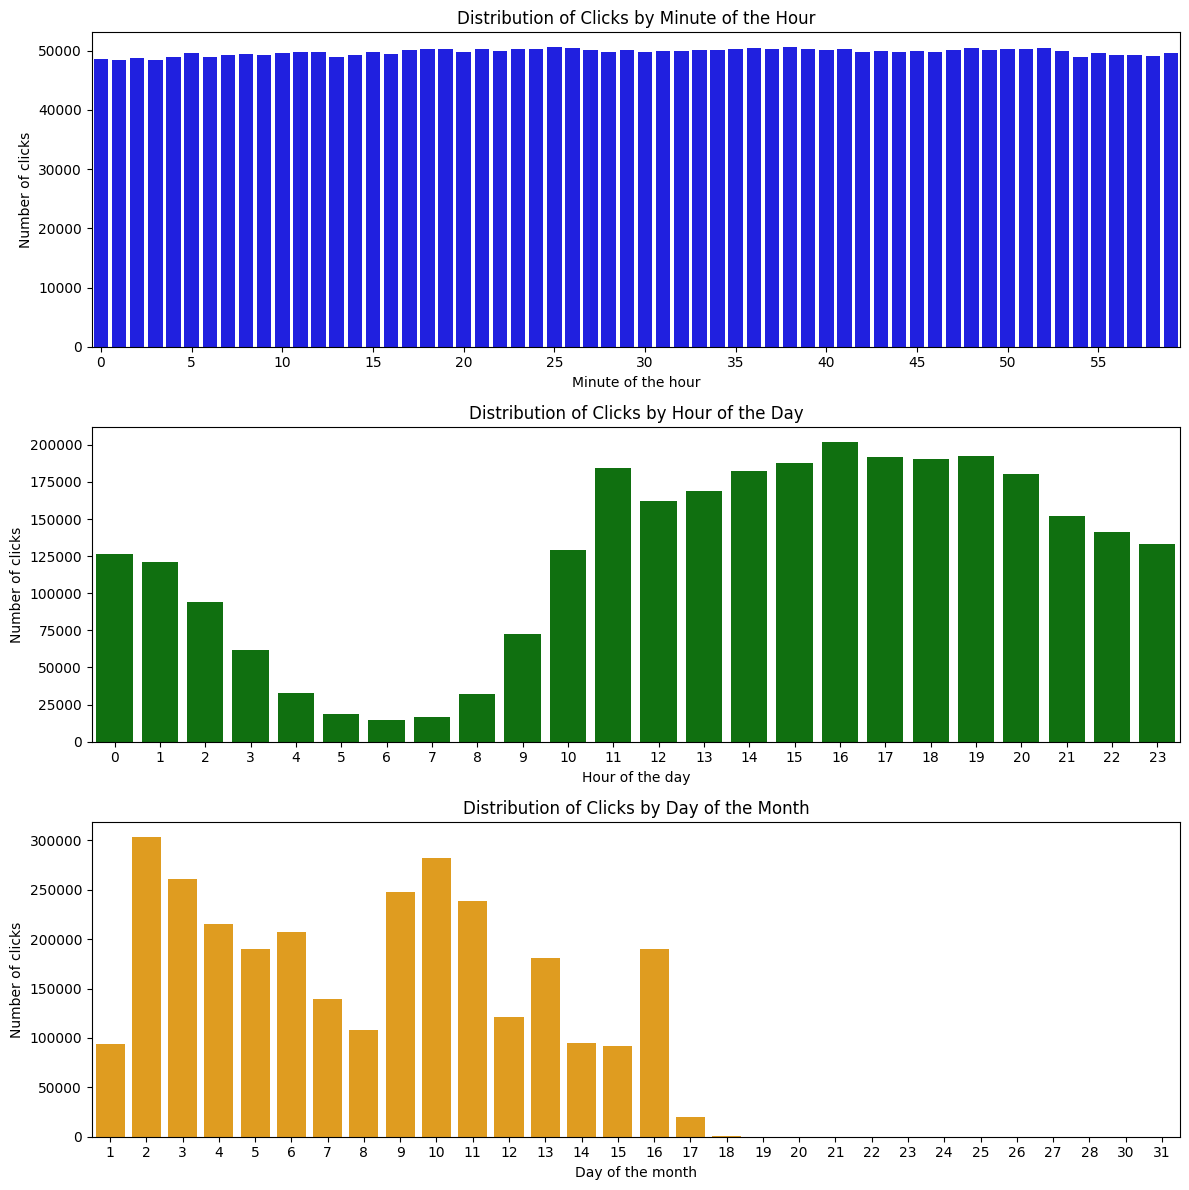

In [92]:
clicks_df = clicks_df.assign(
    **{
        "click_timestamp_M": lambda df: df["click_timestamp"].dt.minute,
        "click_timestamp_H": lambda df: df["click_timestamp"].dt.hour,
        "click_timestamp_D": lambda df: df["click_timestamp"].dt.day,
    }
)

#
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
# Plot countplots of click timestamps by minute, hour, and day
sns.countplot(
    data=clicks_df,
    x="click_timestamp_M",
    ax=ax[0],
    color="blue",
)
ax[0].set(
    xlabel="Minute of the hour",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Minute of the Hour",
    xticks=range(0, 60, 5),
)

sns.countplot(
    data=clicks_df,
    x="click_timestamp_H",
    ax=ax[1],
    color="green",
)
ax[1].set(
    xlabel="Hour of the day",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Hour of the Day",
)

sns.countplot(
    data=clicks_df,
    x="click_timestamp_D",
    ax=ax[2],
    color="orange",
)
ax[2].set(
    xlabel="Day of the month",
    ylabel="Number of clicks",
    title="Distribution of Clicks by Day of the Month",
)
plt.tight_layout()
plt.show()

### Analyse des distributions temporelles des clics

**1. Par minute de l’heure**  
La distribution des clics par minute est très homogène, sans variation notable. Cela indique que les clics sont répartis uniformément au sein de chaque heure, sans effet de bord particulier (pas de pic en début ou fin d’heure).

**2. Par heure de la journée**  
On observe une forte variation selon l’heure :  
- Très peu de clics entre 3h et 8h du matin (activité nocturne faible).
- Forte augmentation à partir de 9h, avec un pic entre 16h et 19h.
- L’activité reste élevée jusqu’à 21h, puis diminue progressivement.
Cela reflète des habitudes classiques de consultation, avec une activité maximale en fin d’après-midi et début de soirée.

**3. Par jour du mois**  
La répartition par jour montre des variations importantes :  
- Certains jours (ex : 1, 2, 10, 11) présentent beaucoup plus de clics que d’autres.
- Quelques jours (fin de mois) ont très peu de clics, ce qui peut indiquer une période de collecte incomplète ou des jours manquants dans le dataset.
- Il peut aussi y avoir des effets de week-end ou d’événements particuliers.

---

**Conclusion :**  
- Les clics sont uniformément répartis dans chaque heure.
- L’activité dépend fortement de l’heure de la journée, avec un pic en fin d’après-midi.
- La collecte par jour n’est pas homogène, il faudra en tenir compte pour l’analyse ou la modélisation (éventuellement filtrer les jours incomplets).

In [93]:
print(
    "Can a user can have read the same article id multiple times in a session?"
    "\n===================================================================="
)
print(
    clicks_df.groupby(["user_id", "session_id", "click_article_id"])
    .size()
    .reset_index(name="count")
    .groupby("count")
    .size()
    .rename_axis(
        "N_times | Count of users who have clicked on the same article id once or more times in the same session",
        axis=0,
    ),
)
print("Answer: No, one article has not been read twice in the same session.")

Can a user can have read the same article id multiple times in a session?
N_times | Count of users who have clicked on the same article id once or more times in the same session
1    2988181
dtype: int64
Answer: No, one article has not been read twice in the same session.
N_times | Count of users who have clicked on the same article id once or more times in the same session
1    2988181
dtype: int64
Answer: No, one article has not been read twice in the same session.


In [94]:
print(
    "Can a user can have read the same article id multiple times through different sessions?"
    "\n======================================================================================="
)
print(
    clicks_df.groupby(["user_id", "click_article_id"])
    .size()
    .reset_index(name="count")
    .groupby("count")
    .size()
    .rename_axis(
        "N_times | Count of users who have clicked on the same article id once or more times through different sessions",
        axis=0,
    ),
)
print(
    "Answer: yes, they can read the same article multiple times through multiple sessions."
)

Can a user can have read the same article id multiple times through different sessions?
N_times | Count of users who have clicked on the same article id once or more times through different sessions
1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
12          3
13          6
16          2
17          1
30          1
31          1
33          3
dtype: int64
Answer: yes, they can read the same article multiple times through multiple sessions.
N_times | Count of users who have clicked on the same article id once or more times through different sessions
1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
12          3
13          6
16          2
17          1
30          1
31          1
33          3
dtype: int64
Answer: yes, they can read the same article multiple times through multiple sessions.


In [95]:
# Split the columns into key columns, categorical columns, and timestamp columns
cat_click_cols = [
    "click_environment",
    "click_deviceGroup",
    "click_os",
    "click_country",
    "click_region",
    "click_referrer_type",
]

Analyse macro de la distribution des variables catégorielles relatives aux clics

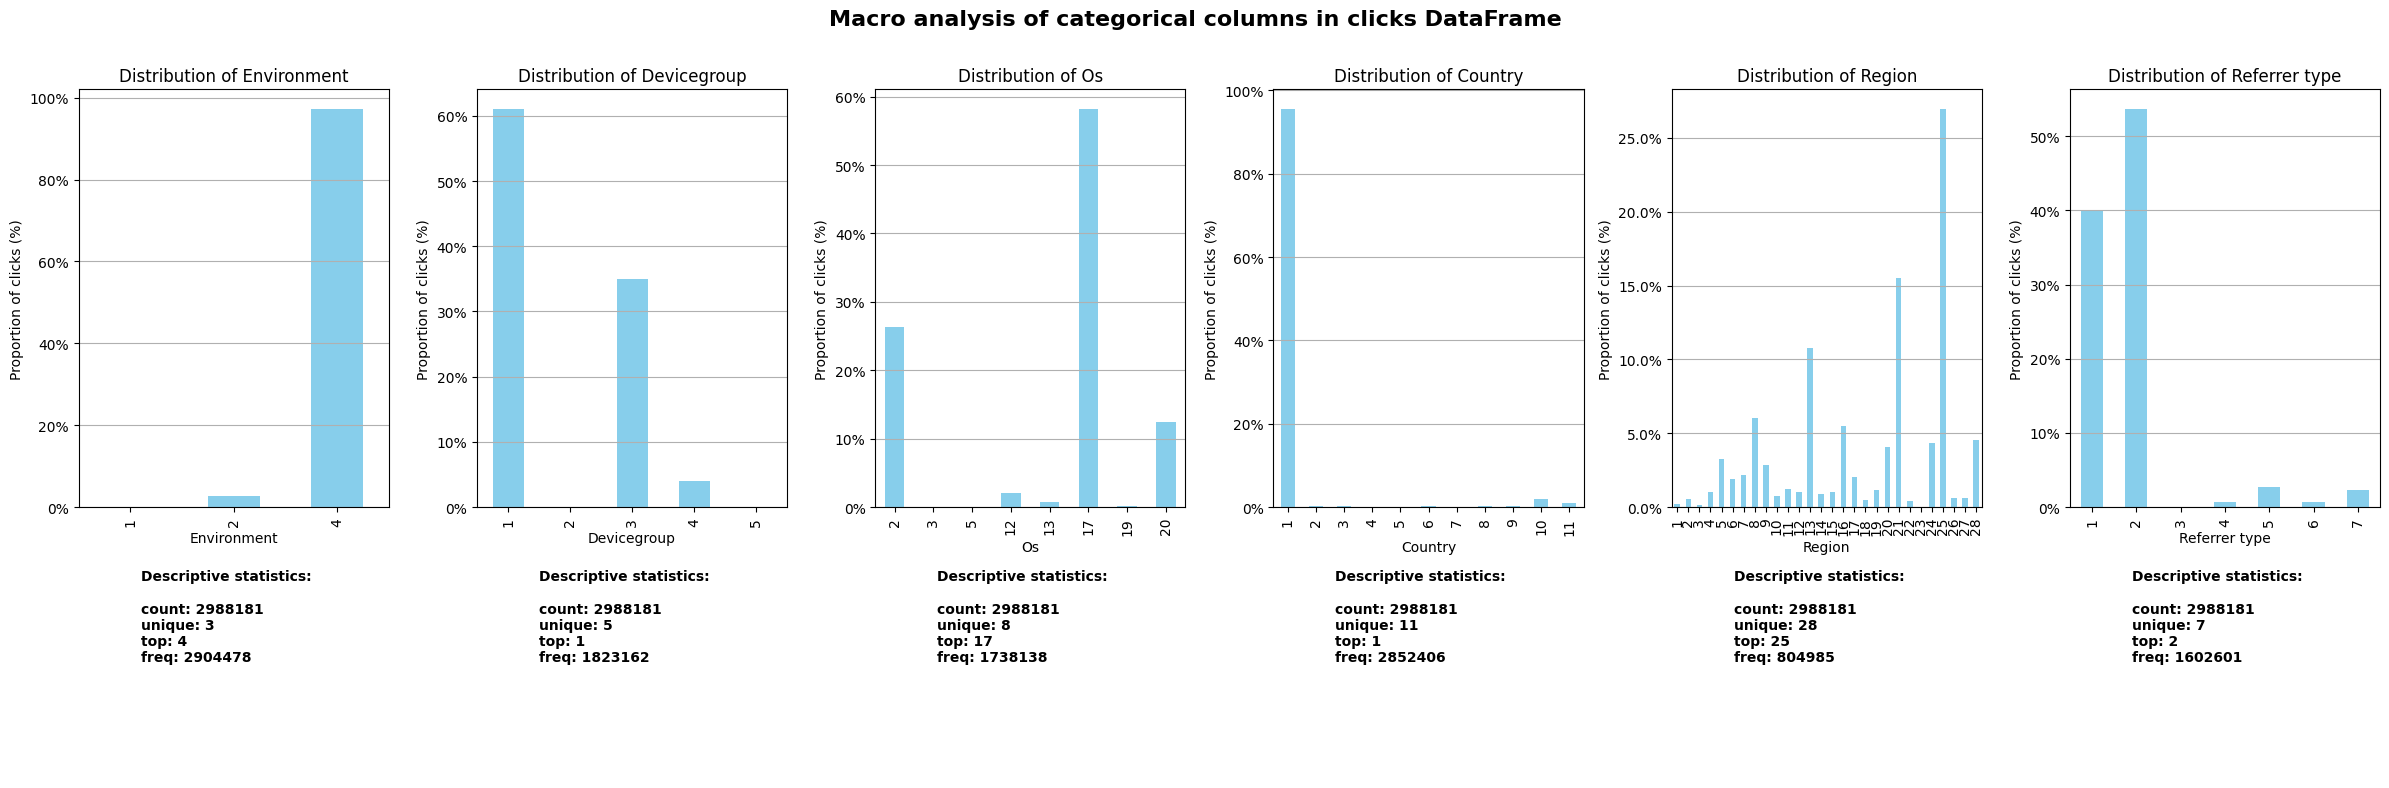

In [96]:
fig, ax = plt.subplots(2, 6, figsize=(24, 8), gridspec_kw={"height_ratios": [1, 0.5]})

fig.suptitle(
    "Macro analysis of categorical columns in clicks DataFrame",
    fontsize=16,
    fontweight="bold",
)
for i, col in enumerate(cat_click_cols):
    proportions = clicks_df[col].value_counts(normalize=True).sort_index()
    proportions.plot(
        kind="bar",
        title=f"Distribution of {col.replace('click_', '').replace('_', ' ').capitalize()}",
        ax=ax[0, i],
        color="skyblue",
    )
    ax[0, i].set_xlabel(col.replace("click_", "").replace("_", " ").capitalize())
    ax[0, i].set_ylabel("Proportion of clicks (%)")
    ax[0, i].grid(axis="y")
    ax[0, i].yaxis.set_major_formatter(PercentFormatter(xmax=1))
    stats_text = "\n".join(
        [
            f"{key}: {value:.9g}"
            for key, value in clicks_df[col].astype("category").describe().items()
        ]
    )
    stats_text = "Descriptive statistics:\n\n" + stats_text
    ax[1, i].text(
        0.2,
        1.0,
        stats_text,
        transform=ax[1, i].transAxes,
        fontsize=10,
        fontweight="bold",
        verticalalignment="top",
        horizontalalignment="left",
    )
    ax[1, i].axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Here’s a quick walkthrough of what each plot tells us and how you can leverage these insights in your recommender:

• click_environment  
  – Almost 97 % of clicks come from environment code “4” (e.g. the main web‐site or app). The other environments are marginal.  
  → You can treat “main environment” vs “others” as a binary context feature: maybe only show certain rich media formats in the dominant environment.

• click_deviceGroup  
  – About 60 % desktop, 35 % mobile, the rest on tablets/TV/etc.  
  → Use device type to adjust layout or content length. On mobile, favor shorter reads; on desktop show multi‐column widgets.

• click_os  
  – One OS (code 17, likely Android or iOS) accounts for 58 % of clicks; the next (code 2) about 27 %.  
  → If you run A/B tests or serve native features (push notifications, deep links), tailor them by OS.

• click_country & click_region  
  – >95 % of clicks from country “1” (Brazil), and a handful of regions dominate.  
  → Geo‐target articles: boost local news or filter out irrelevant regions. In cold‐start, fall back to majority‐region preferences.

• click_referrer_type  
  – 55 % “direct” (none), 40 % “search,” ~5 % social.  
  → For social referrals, highlight “viral” or highly shareable items; for search traffic, emphasize deep‐dive/content‐rich articles.

Conclusion  
All these categorical variables are **perfect candidates for context‐aware features** or **user segmentation** in your recommender. They won’t directly predict content preference but will help you:  
  1. Personalize **presentation** (format, layout)  
  2. Segment users for **targeted ranking** or **A/B tests**  
  3. Provide **context features** to hybrid/collaborative models, improving click‐through and satisfaction.

In [97]:
print(
    "Can a user can click from one environment to another one in the same session?"
    "\n===================================================================="
)
print(
    clicks_df.groupby(["user_id", "session_id"])["click_environment"]
    .nunique()
    .value_counts()
)
print("Answer: yes but in some very rare cases.")

Can a user can click from one environment to another one in the same session?
click_environment
1    1048106
2        488
Name: count, dtype: int64
Answer: yes but in some very rare cases.
click_environment
1    1048106
2        488
Name: count, dtype: int64
Answer: yes but in some very rare cases.


In [98]:
clicks_df = clicks_df.merge(
    clicks_df["click_article_id"]
    .value_counts(normalize=True)
    .rename("article_popularity")
    .reset_index(),
    on="click_article_id",
    how="left",
).assign(
    **{
        "log_article_popularity": lambda df: np.log(
            df["article_popularity"] / (1 - df["article_popularity"])
        ),
    }
)


clicks_df = clicks_df.sort_values(
    ["session_start", "click_timestamp"], ascending=True
).assign(
    **{
        "read_duration": lambda df: df.groupby("session_id")["click_timestamp"]
        .diff()
        .shift(-1)
        .dt.total_seconds()
        .replace({30.0: np.nan}),
        "click_ranking": lambda df: df.groupby("session_id")["click_timestamp"]
        .rank(method="first")
        .astype(int),
    }
)

# Calcul de la durée moyenne par article (en excluant les valeurs manquantes)
median_duration_per_article = clicks_df.groupby("click_article_id")[
    "read_duration"
].median()

# Imputation de la durée manquante par la moyenne de l'article correspondant
clicks_df["read_duration"] = (
    clicks_df["read_duration"]
    .fillna(clicks_df["click_article_id"].map(median_duration_per_article))
    .fillna(median_duration_per_article.median())
)

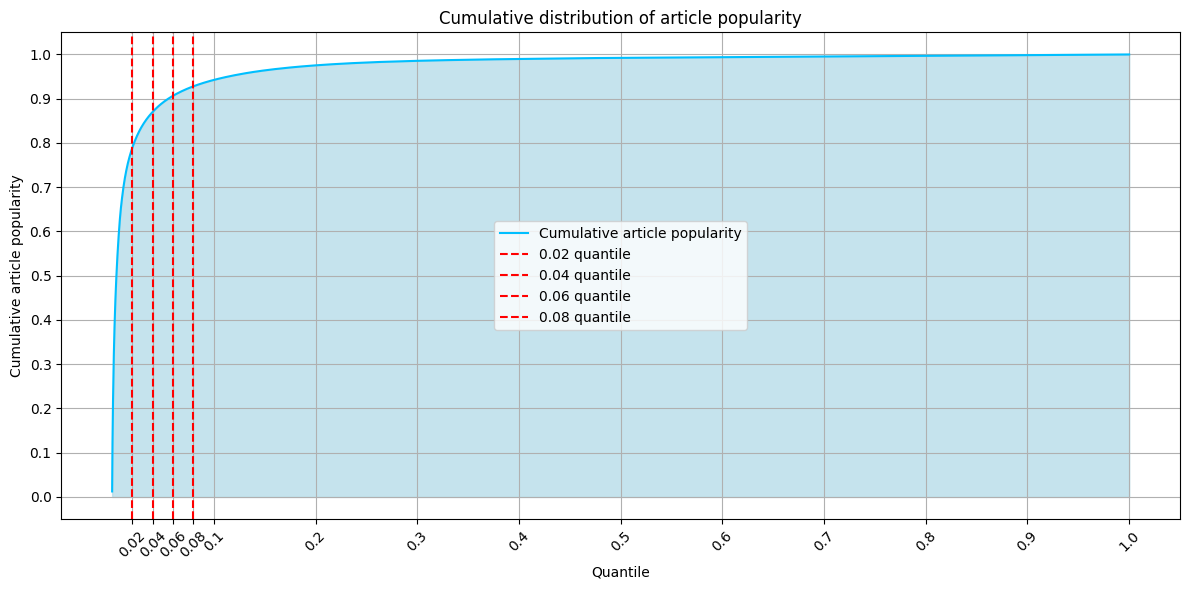

In [99]:
cum_pop = (
    clicks_df.groupby("click_article_id")["article_popularity"]
    .first()
    .sort_values(ascending=False)
    .cumsum()
    .reset_index(drop=True)
)

quantiles = np.arange(0.1, 1.01, 0.1)
quantile_indices = (quantiles * (len(cum_pop) - 1)).astype(int)
quantile_labels = [f"{q:.1f}" for q in quantiles]

quantiles_ = np.array([0.02, 0.04, 0.06, 0.08])
quantile_indices_ = (quantiles_ * (len(cum_pop) - 1)).astype(int)
quantile_labels_ = [f"{q:.2f}" for q in quantiles_]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    cum_pop.index,
    cum_pop.values,
    color="deepskyblue",
    label="Cumulative article popularity",
)
ax.fill_between(
    cum_pop.index,
    cum_pop.values,
    color="lightblue",
    alpha=0.7,
)
for idx, quant in enumerate(quantiles_):
    ax.axvline(
        quantile_indices_[idx],
        color="red",
        linestyle="--",
        label=f"{quantile_labels_[idx]} quantile",
    )
ax.set_title("Cumulative distribution of article popularity")
ax.set_xlabel("Quantile")
ax.set_ylabel("Cumulative article popularity")
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.concatenate((quantile_indices_, quantile_indices)))
ax.set_xticklabels(quantile_labels_ + quantile_labels, rotation=45)
ax.grid(axis="both")
ax.legend()
plt.tight_layout()
plt.show()

<Axes: >

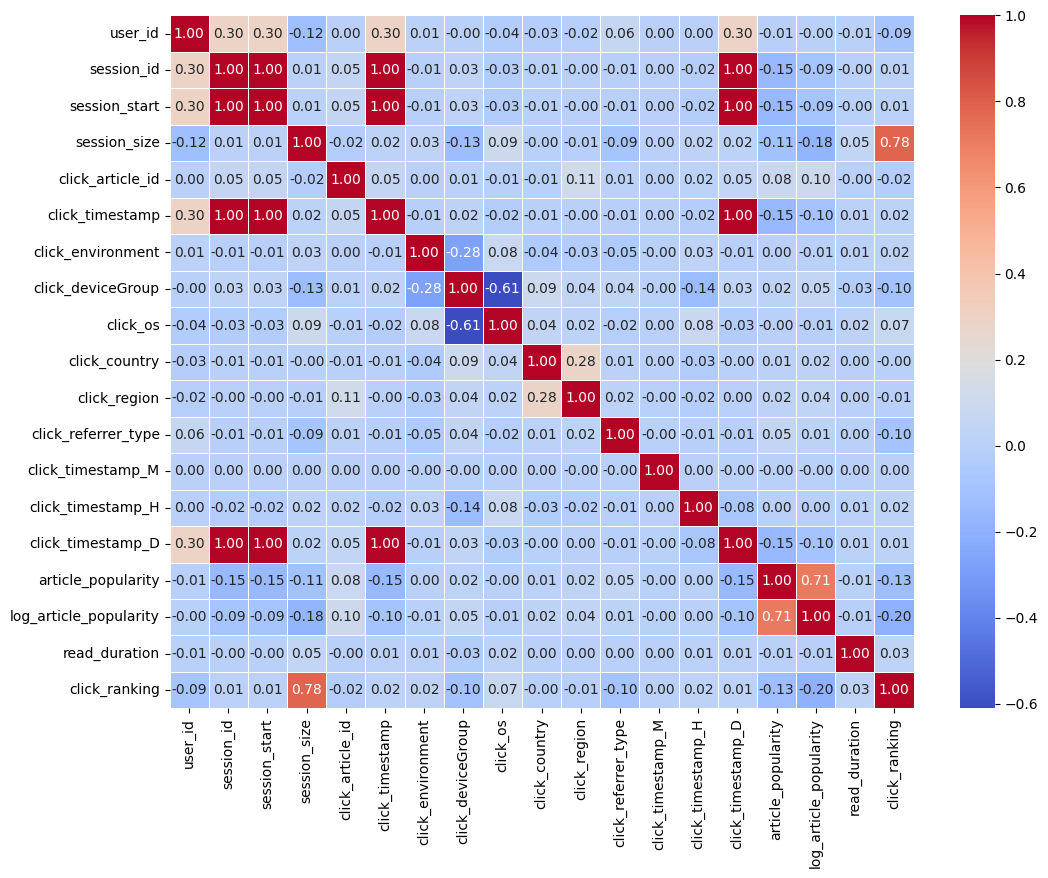

In [116]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    clicks_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax
)

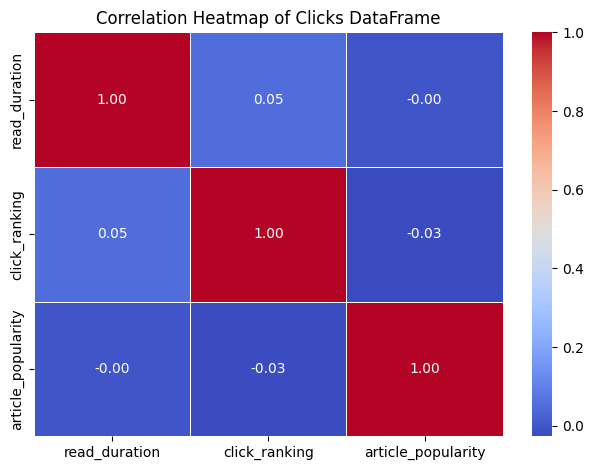

In [139]:
sns.heatmap(
    clicks_df.groupby("click_article_id")[
        ["read_duration", "click_ranking", "article_popularity"]
    ]
    .mean()
    .corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Heatmap of Clicks DataFrame")
plt.tight_layout()
plt.show()

<Axes: xlabel='click_timestamp_D'>

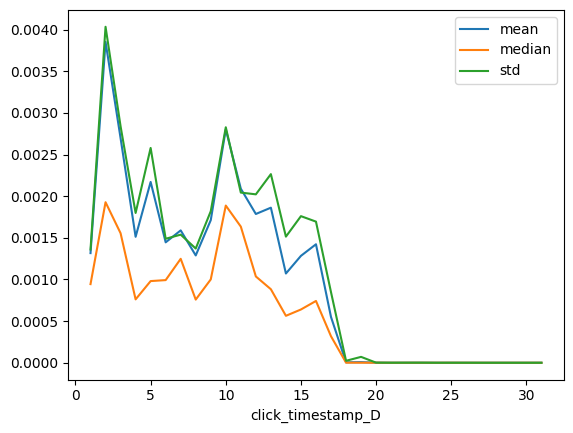

In [118]:
clicks_df.groupby("click_timestamp_D")["article_popularity"].aggregate(
    ["mean", "median", "std"]
).plot(kind="line")


<Axes: >

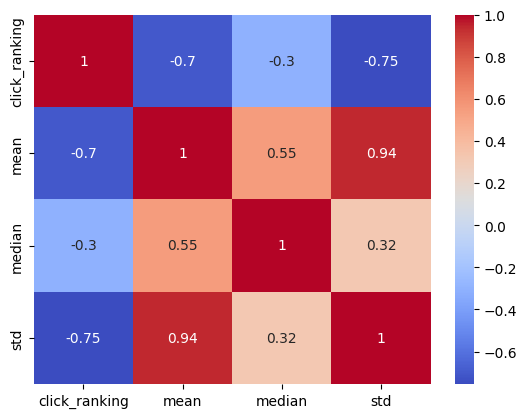

In [129]:
clicks_stats = clicks_df.groupby("click_ranking")["article_popularity"].aggregate(
    ["mean", "median", "std"]
)

sns.heatmap(
    clicks_stats.reset_index().corr(method="spearman"), annot=True, cmap="coolwarm"
)

In [130]:
print(clicks_stats.sort_values("mean", ascending=False).head(10))

                   mean    median       std
click_ranking                              
1              0.002449  0.001488  0.002662
2              0.002099  0.001115  0.002486
83             0.001862  0.000021  0.003109
3              0.001823  0.000887  0.002323
4              0.001598  0.000674  0.002202
5              0.001417  0.000436  0.002085
6              0.001242  0.000313  0.001958
7              0.001124  0.000228  0.001869
8              0.001000  0.000188  0.001749
9              0.000908  0.000151  0.001675


In [131]:
print(clicks_stats.sort_values("median", ascending=False).head(10))

                   mean    median       std
click_ranking                              
1              0.002449  0.001488  0.002662
2              0.002099  0.001115  0.002486
3              0.001823  0.000887  0.002323
110            0.000845  0.000845       NaN
107            0.000806  0.000806  0.000419
4              0.001598  0.000674  0.002202
113            0.000633  0.000633       NaN
104            0.000724  0.000529  0.000687
5              0.001417  0.000436  0.002085
103            0.000470  0.000414  0.000486


## Metadata

In [161]:
articles_df = pd.read_csv(WORK_DIR / "articles_metadata.csv").sort_values(
    "article_id", ascending=True
)

In [162]:
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [163]:
# Define timestamps columns
timestamp_cols = ["created_at_ts"]

# Convert timestamp columns to datetime and numeric types to best integer type to save memory
articles_df = articles_df.assign(
    **{
        col: lambda df, col=col: pd.to_datetime(df[col], unit="ms")
        for col in timestamp_cols
    }
).assign(
    **{
        col: lambda df, col=col: pd.to_numeric(df[col], downcast="integer")
        for col in articles_df.columns
        if col not in timestamp_cols
    }
)

# Display the info
print(articles_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  int32         
 1   category_id    364047 non-null  int16         
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  int8          
 4   words_count    364047 non-null  int16         
dtypes: datetime64[ns](1), int16(2), int32(1), int8(1)
memory usage: 5.9 MB
None


In [164]:
print(articles_df.isnull().sum())

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64


In [165]:
print(articles_df.duplicated().sum())

0


<Axes: xlabel='words_count', ylabel='Count'>

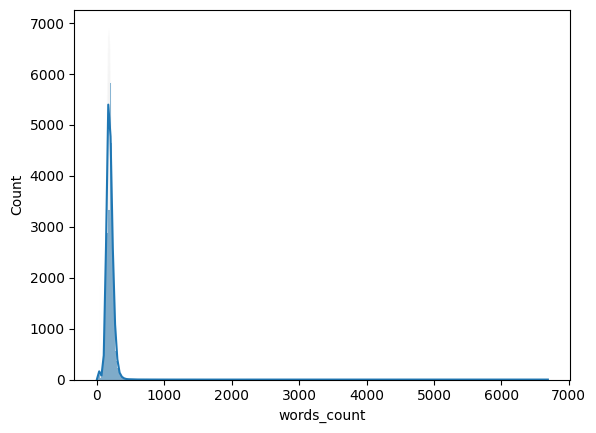

In [166]:
sns.histplot(articles_df["words_count"], kde=True)

In [168]:
print(articles_df["words_count"].quantile(0.01))
print(articles_df["words_count"].quantile(0.99))

46.0
336.0


In [169]:
print(articles_df["words_count"].describe())

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64


**Constat effectué sur le `words_count`** : Nécessité d'appliquer un threshold pour écarter les outliers. Par simplicité, on prendra les quantiles 0.01 et 0.99 pour filtrer les valeurs extrêmes.

In [170]:
print(articles_df.filter(["category_id", "publisher_id"]).nunique())

category_id     461
publisher_id      1
dtype: int64


<Axes: title={'center': 'Distribution of articles by category_id'}, xlabel='Category ID', ylabel='Count of articles'>

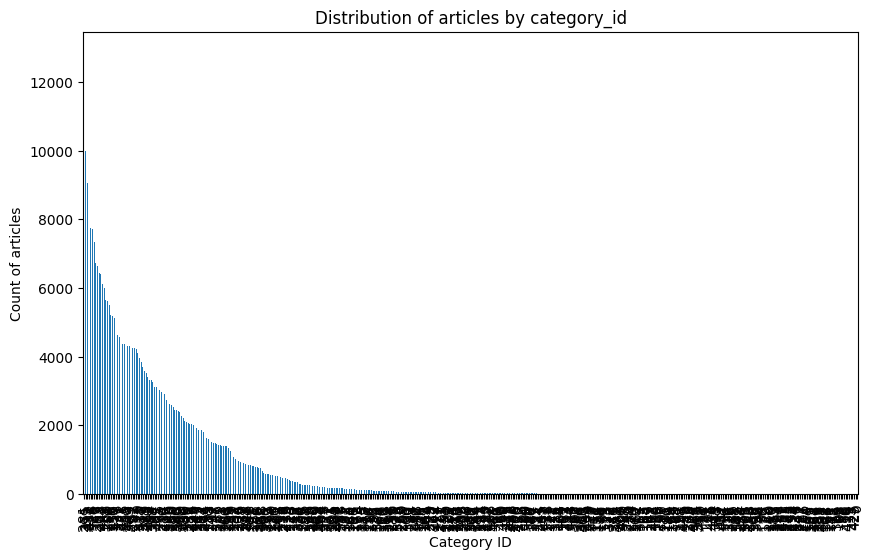

In [39]:
articles_df["category_id"].value_counts().plot.bar(
    title="Distribution of articles by category_id",
    xlabel="Category ID",
    ylabel="Count of articles",
    figsize=(10, 6),
)

# Embeddings

In [ ]:
embeddings_array = pd.read_pickle(WORK_DIR / "articles_embeddings.pickle")
embeddings_df = pd.DataFrame(embeddings_array)
print("Embeddings DataFrame shape:", embeddings_array.shape)
from sklearn.cluster import KMeans
from tqdm import tqdm

clusters_range = range(5, 90, 5)
inertia_scores = []
clusters_df = pd.DataFrame(index=embeddings_df.index)
for n_cluster in tqdm(clusters_range):
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, random_state=42)
    labels = kmeans.fit_predict(embeddings_df)
    clusters_df[f"cluster_{n_cluster}"] = labels
    inertia_scores.append(kmeans.inertia_)
# plot inertia scores
plt.figure(figsize=(14, 6))
plt.plot(clusters_range, inertia_scores, marker="o")
plt.title("Inertia Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.xticks(clusters_range)
plt.grid()
plt.show()

In [ ]:
# merge articles_df with embeddings_df
kmeans_df = articles_df.filter(
    ["article_id", "category_id", "created_at_ts", "words_count"]
).merge(embeddings_df[["cluster"]], left_index=True, right_index=True, how="left")

In [ ]:
# make a TSNE on on the embeddings_df
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_df.drop(columns=["cluster"]))
tsne_df = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
# merge tsne_df with kmeans_df
kmeans_df = kmeans_df.merge(tsne_df, left_index=True, right_index=True, how="left")
# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=kmeans_df,
    x="x",
    y="y",
    hue="cluster",
    palette="Set1",
    alpha=0.7,
    s=100,
)
plt.title("Clusters of Articles based on Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
# Make another scatterplot wiith hue as category_id
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=kmeans_df,
    x="x",
    y="y",
    hue="category_id",
    palette="Set1",
    alpha=0.7,
    s=100,
)
plt.title("Clusters of Articles based on Embeddings and Category ID")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()

# Fusion des données

In [40]:
merged_df = clicks_df.merge(
    articles_df, left_on="click_article_id", right_on="article_id", how="left"
)
print("Merged DataFrame shape:", merged_df.shape)

Merged DataFrame shape: (2988181, 20)


In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 20 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int32         
 1   session_id           int64         
 2   session_start        datetime64[ns]
 3   session_size         int8          
 4   click_article_id     int32         
 5   click_timestamp      datetime64[ns]
 6   click_environment    int8          
 7   click_deviceGroup    int8          
 8   click_os             int8          
 9   click_country        int8          
 10  click_region         int8          
 11  click_referrer_type  int8          
 12  click_timestamp_M    int32         
 13  click_timestamp_H    int32         
 14  click_timestamp_D    int32         
 15  article_id           int32         
 16  category_id          int16         
 17  created_at_ts        datetime64[ns]
 18  publisher_id         int8          
 19  words_count          

In [43]:
merged_df.isnull().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
click_timestamp_M      0
click_timestamp_H      0
click_timestamp_D      0
article_id             0
category_id            0
created_at_ts          0
publisher_id           0
words_count            0
dtype: int64

In [44]:
merged_df.duplicated().sum()

np.int64(0)